In [1]:
import os
import numpy as np
import random
import timeit

from bisect import bisect_right, bisect_left

In [2]:
class Rectangle():
    def __init__(self, x, y, width, height):
        self.x = x
        self.y = y
        self.width = width
        self.height = height

In [3]:
class UUIDRectangle(Rectangle):
    def __init__(self, x, y, width, height, uuid):
        super().__init__(x, y, width, height)
        self.assigned_to_set = False
        self.uuid = uuid

In [4]:
class PrintUtils():
    def PrintMaximalSet(maximal_set):
        for i, rectangle in enumerate(maximal_set):
            if i < len(maximal_set) - 1:
                print("{}, ".format(rectangle.uuid), end = '')
            else: 
                print("{}".format(rectangle.uuid), end = '')
                
    def PrintMaximalSets(maximal_sets):
        for maximal_set in sorted(maximal_sets, key=len, reverse=True):
            PrintMaximalSet(maximal_set)
            print('')

In [5]:
def IntersectingRectanglesByAxis(curr, rectangles, axis, dimension):
    rectangles.sort(key=lambda r: getattr(r, axis) + getattr(r, dimension))
    upper_right_corners = [getattr(r, axis) + getattr(r, dimension) for r in rectangles] 
    idx = bisect_right(upper_right_corners, getattr(curr, axis))
    rectangles = rectangles[max(0,idx):]

    rectangles.sort(key=lambda r: getattr(r, axis))
    lower_left_corners = [getattr(r, axis) for r in rectangles] 
    idx = bisect_left(lower_left_corners, getattr(curr, axis) + getattr(curr, dimension))
    rectangles = rectangles[0:min(idx, len(rectangles))]
        
    return rectangles

def GetIntersectingRectangles(curr, rectangles):
    rectangles = IntersectingRectanglesByAxis(curr, rectangles, 'x', 'width')
    rectangles = IntersectingRectanglesByAxis(curr, rectangles, 'y', 'height')
    
    return rectangles

In [15]:
def CreateRectanglesFromData():
    rectangles = []
    data = np.loadtxt(os.getcwd() + '/data/rectangles.txt')

    for i in range(0, data.shape[0]):
        rectangle = UUIDRectangle(data[i,0], data[i,0], data[i,0], data[i,0], i)
        rectangles.append(rectangle)
    
    return rectangles

In [16]:
def BuildGraph(rectangles):
    G = {}
    for r in list(rectangles):
        G[r.uuid] = []
        intersects = GetIntersectingRectangles(r, rectangles)
        for i in intersects:
            if i.uuid == r.uuid: continue
            G[r.uuid].append(i.uuid)
                
    return G

In [17]:
def BK(R, P, X, G, max_sets):
    if len(P) == 0 and len(X) == 0:
        max_sets.append(R)
    
    for v in list(P):
        N_v = set(G[v])
        max_sets = BK(R.union(set({v})), P.intersection(N_v), X.intersection(N_v), G, max_sets)
        P.remove(v)
        X.add(v)
        
    return max_sets

In [38]:
def BKPivot(R, P, X, G, max_sets):
    if len(P) == 0 and len(X) == 0:
        max_sets.append(R)
    
    tmp = P.union(X)
    if len(tmp) > 0:
        u = random.sample(tmp, 1)[0]
        N_u = set(G[u])
        for v in list(P.difference(N_u)):
            N_v = set(G[v])
            max_sets = BKPivot(R.union(set({v})), P.intersection(N_v), X.intersection(N_v), G, max_sets)
            P.remove(v)
            X.add(v)
        
    return max_sets

In [40]:
def BKPivotByDegree(R, P, X, G, max_sets, rs, vs_by_degree):
    if len(P) == 0 and len(X) == 0:
        PrintMaximalSet(R)
        max_sets.append(R)
        
    tmp = P.union(X)
    i = 0
    while True:
        if vs_by_degree[i] in tmp:
            u = vs_by_degree[i]
            break
        i += 1
    del vs_by_degree[i]

    N_u = set(G[u])
    for v in list(P.difference(N_u)):
        N_v = set(G[v])
        max_sets = BKPivot(R.union(set({v})), P.intersection(N_v), X.intersection(N_v), G, max_sets)
        P.remove(v)
        X.add(v)
        
    return max_sets

In [41]:
def FindMaximalSets(rectangles, pivot = False, by_degree = False):
    R = set()
    X = set()
    G = BuildGraph(rectangles)
    P = set(G.keys())
    max_sets = []
    
    if pivot:
        return BKPivot(R, P, X, G, max_sets)
    elif by_degree:
        vs_by_degree = sorted(G, key=lambda k: len(G[k]), reverse=True)
        return BKPivotByDegree(R, P, X, G, max_sets, rectangles, vs_by_degree)
    else:
        return BK(R, P, X, G, max_sets)

In [42]:
rectangle_1 = UUIDRectangle(1, 1, 5, 5, 1)
rectangle_2 = UUIDRectangle(4, 4, 3, 3, 2)
rectangle_3 = UUIDRectangle(6, 1, 1, 1, 3)
rectangle_4 = UUIDRectangle(2, 2, 3, 3, 4)
rectangle_5 = UUIDRectangle(1, 4, 1, 3, 5)
rectangles = [rectangle_1, rectangle_2, rectangle_3, rectangle_4, rectangle_5]

FindMaximalSets(rectangles)

[{1, 2, 4}, {1, 5}, {3}]

In [43]:
FindMaximalSets(CreateRectanglesFromData()[0:20])

[{0, 1, 3, 5, 8, 12, 13, 14, 16, 17, 18},
 {1, 2, 3, 6, 8, 11, 15, 16},
 {2, 6, 7, 11, 15},
 {4},
 {7, 19},
 {9},
 {10}]

In [44]:
test1 = FindMaximalSets(CreateRectanglesFromData()[100:140], pivot=True)

In [45]:
test1 = FindMaximalSets(CreateRectanglesFromData()[100:140], by_degree=True)

In [28]:
print("BK time: {}".format(timeit.timeit(stmt='''{} '''.format(FindMaximalSets(CreateRectanglesFromData()[0:20])))))

BK time: 0.7163177430002179


In [29]:
print("BK area time: {}".format(timeit.timeit(stmt='''{} '''.format(FindMaximalSets(CreateRectanglesFromData()[0:30], by_degree= True)))))

BK area time: 1.0253298729999187


In [32]:
data = np.loadtxt("data/rectangles.txt")

In [33]:
data.shape

(100000, 4)

In [34]:
import matplotlib.pyplot as plt

In [ ]:
plt.figure(figsize=(8, 5))
import matplotlib.cm as cm
rectangles = CreateRectanglesFromData()[0:1000]
G = BuildGraph(rectangles)

for r in rectangles:
    plt.scatter(r.x, r.y, c=len(G[r.uuid])/5000)
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
import matplotlib.cm as cm
c_in = data[:,3]*data[:,2]
c_in = c_in / np.amax(c_in)
colors = cm.rainbow(c_in)

plt.scatter(data[:,0], data[:,1], c=colors)
plt.colorbar()
plt.show()

In [ ]:
def BuildSampleGraphDegrees(N):
    D = []
    for n in range(0,20):
        G = BuildGraph(random.sample(CreateRectanglesFromData(), N)) 
        for v in G:
            D.append(len(G[v]))
    
    return D

N = 6
fig, axes = plt.subplots(nrows=1, ncols=N, figsize=(22, 6))
V_list = [10, 50, 100, 500, 1000, 5000]
D_list = []
for i, ax in enumerate(axes.flatten()):
    num_v = V_list[i]
    D = BuildSampleGraphDegrees(num_v)
    hist, bins = np.histogram(np.asarray(D), bins=30)
    ax.hist(D, bins)
    ax.title.set_text("|V|: {:.1f}, D_avg: {:.1f}".format(num_v, sum(D)/len(D)))
    
    D_list.append(sum(D)/len(D))

plt.show()

In [ ]:
fig1, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
plt.plot(V_list, D_list)
plt.title("Avg degree vs |V|")
plt.xlabel("Number of vertices, |V|")
plt.ylabel("Avg vertex degree")
plt.show()

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(data[0:100,0], data[0:100,1])
plt.scatter(data[1000:1100,0], data[1000:1100,1])
plt.scatter(data[10000:10100,0], data[10000:10100,1])
plt.show()

In [35]:
np.unique(data, axis=0).shape

(33241, 4)

In [36]:
np.unique(data[:,0:2], axis=0).shape

(400, 2)

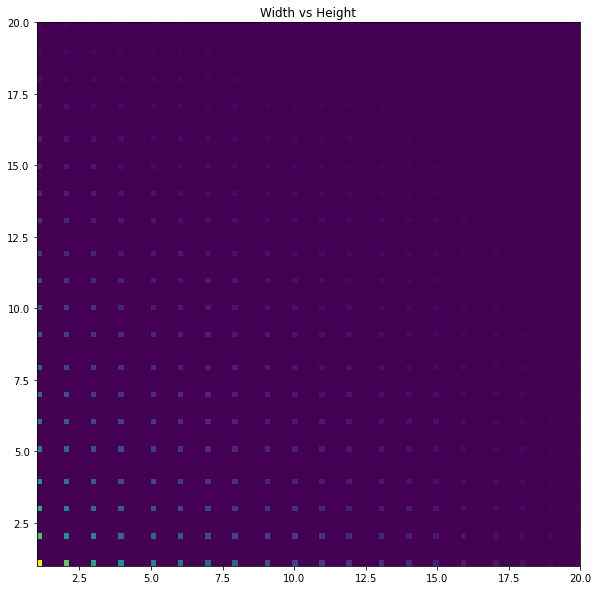

In [46]:
H, xedges, yedges = np.histogram2d(data[:,2], data[:,3], bins=100)
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, title='Width vs Height', aspect='equal')
X, Y = np.meshgrid(xedges, yedges)
ax.pcolormesh(X, Y, H)
plt.show()

In [ ]:
hist, bins = np.histogram(data[:,2], bins=20)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.hist(data[:,0], bins)
ax1.title.set_text('Width')

hist, bins = np.histogram(data[:,3], bins=20)
ax2.hist(data[:,3], bins)
ax2.title.set_text('Height')

hist, bins = np.histogram(data[:,2]*data[:,3], bins=20)
ax3.hist(data[:,2]*data[:,3], bins)
ax3.title.set_text('Area')
    
fig.set_figheight(5)
fig.set_figwidth(15)
plt.show()

In [ ]:
idx_max = np.argmax(data[:,2]*data[:,3])

In [ ]:
data[idx_max,:]